In [2]:
import torch
print(torch.cuda.is_available())


False


In [ ]:
! pip install SentencePiece


In [ ]:
! pip install transformers


In [ ]:
! pip install pandas

In [ ]:
! pip install -U matplotlib

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams["figure.figsize"] = 16, 12

In [3]:
class QuotesDataset(Dataset):
    def __init__(self, quotes, tokenizer):
        self.quotes = quotes
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.quotes)

    def __getitem__(self, idx):
        text = self.quotes[idx]
        inputs = self.tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=1024)
        return torch.tensor(inputs)

In [4]:
full_dataset =pd.read_csv('quotes_dataset_final_small.csv',low_memory=False)
full_dataset=full_dataset.head(50)

In [5]:
quotes = full_dataset['quotes']
tokenizer = T5Tokenizer.from_pretrained('t5-base')

# add padding token to tokenizer vocabulary
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    print('Added padding token to tokenizer')


tokenizer.pad_token = '[PAD]'
dataset = QuotesDataset(quotes, tokenizer)

c:\CS\CSC561\T5\.conda\lib\site-packages\transformers\models\t5\tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [6]:
batch_size=1
num_epochs=10
lr=2e-5

In [7]:
model = T5ForConditionalGeneration.from_pretrained('t5-base')
optimizer = AdamW(model.parameters(), lr=lr)

c:\CS\CSC561\T5\.conda\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


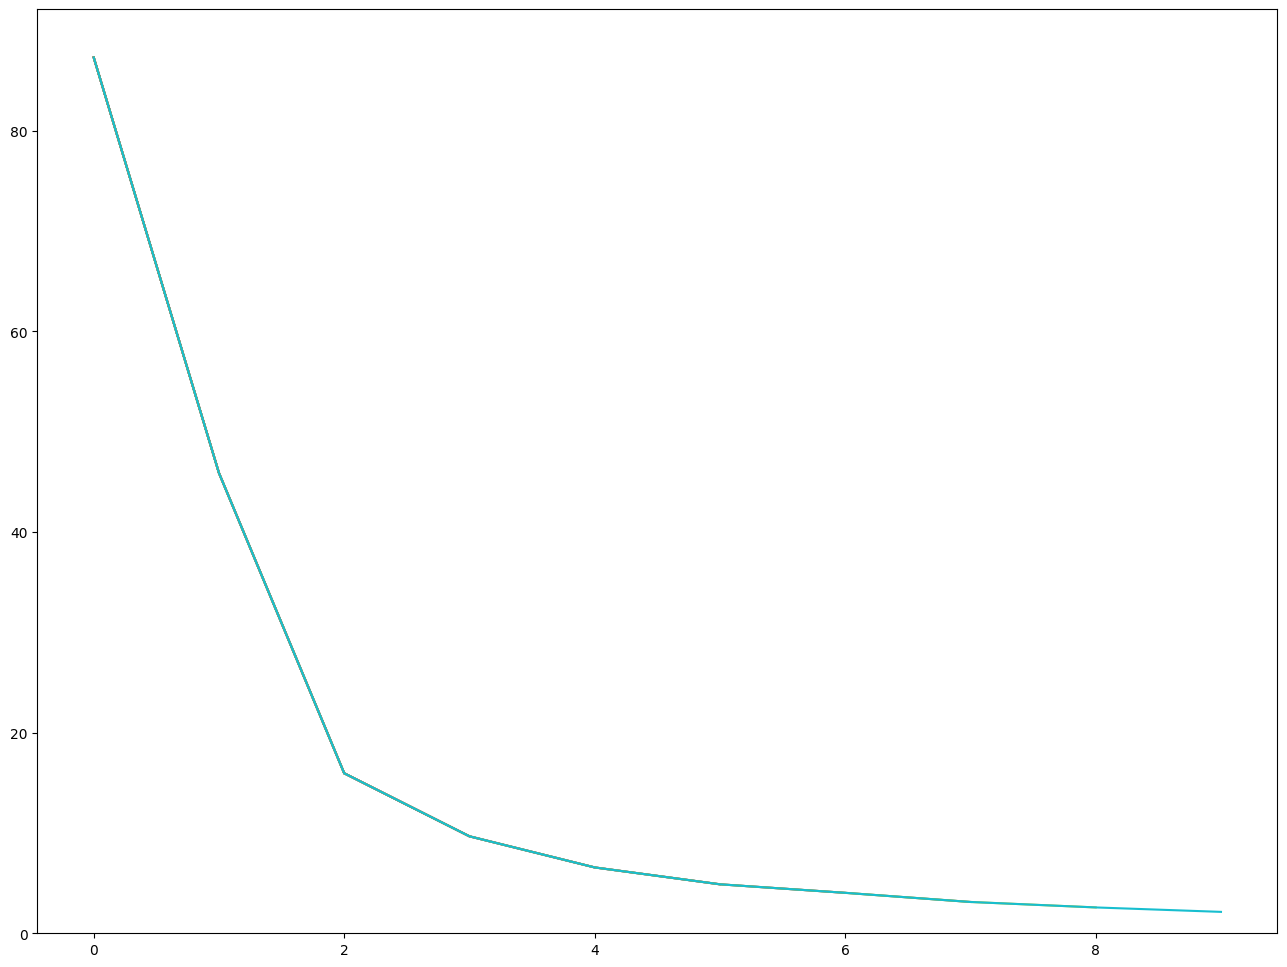

In [10]:
all_training_loss=[]
for epoch in range(num_epochs):
    tr_epoch_loss = 0
    model.train()
    for batch in dataloader:
        # Pad each sequence to the maximum length in the batch
        batch = pad_sequence(batch, batch_first=True, padding_value=tokenizer.pad_token_id)
        batch = batch.to(model.device)
        outputs = model(input_ids=batch, labels=batch)
        
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        tr_epoch_loss += loss.item()
        optimizer.step()
    
    all_training_loss.append(tr_epoch_loss)
    plt.plot(all_training_loss)
    plt.ylim(bottom=0)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    # Save the model after each epoch
    torch.save(model.state_dict(), f't5_finetuned_epoch_{epoch}.pt')

In [11]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the fine-tuned GPT-2 model and tokenizer
# Load the model checkpoint
model_path = "t5_finetuned_epoch_9.pt"
model_state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Create a new model and load the state dict
model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.load_state_dict(model_state_dict)
tokenizer = T5Tokenizer.from_pretrained('t5-base')

# Generate new quotes
prompt = "Life is a journey"
input_ids = tokenizer.encode(prompt, add_special_tokens=True, return_tensors='pt')
output = model.generate(input_ids=input_ids, max_length=20, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True)
generated_quotes = [tokenizer.decode(seq, clean_up_tokenization_spaces=True) for seq in output]

# Print the generated quotes
print(generated_quotes)

['<pad> Life is a journey. Life are s journeys.</s>']
